_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c3_interpolated_2250_100.csv")
training_set = data.iloc[:, 1]
training_set

0       91.100000
1       90.875910
2       90.651821
3       90.427731
4       90.203641
          ...    
2345    67.967958
2346    67.961672
2347    67.955387
2348    67.949102
2349    67.942816
Name: C3, Length: 2350, dtype: float64

In [6]:
test = training_set.tail(100)
test
training_set = training_set.head(2250)
training_set

0       91.100000
1       90.875910
2       90.651821
3       90.427731
4       90.203641
          ...    
2245     0.000000
2246     0.000000
2247     0.059959
2248     0.000000
2249     0.965788
Name: C3, Length: 2250, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,91.100000,0.000298
1,90.875910,0.000298
2,90.651821,0.000297
3,90.427731,0.000297
4,90.203641,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

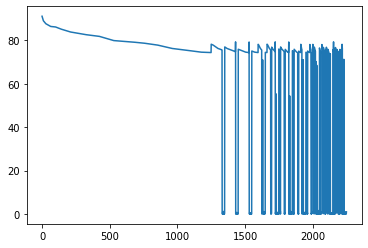

In [10]:
df.iloc[:, 0].plot()

C:\Users\Anurag Dutta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

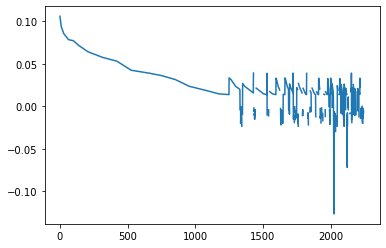

In [11]:
import numpy as np
c0 = 88.0403  # Value for C0
K0 = -0.0012  # Value for K0
K1 = -0.0001  # Value for K1
a = 0.0000    # Value for a
b = 0.0120    # Value for b
c = 2.0334    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 350, n_out = 100)


cols_to_drop = []
for i in range(2, 351):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-350)  var1(t-349)  var1(t-348)  var1(t-347)  var1(t-346)  \
350    91.100000    90.875910    90.651821    90.427731    90.203641   
351    90.875910    90.651821    90.427731    90.203641    89.979552   
352    90.651821    90.427731    90.203641    89.979552    89.755462   
353    90.427731    90.203641    89.979552    89.755462    89.531373   
354    90.203641    89.979552    89.755462    89.531373    89.307283   

     var1(t-345)  var1(t-344)  var1(t-343)  var1(t-342)  var1(t-341)  ...  \
350    89.979552    89.755462    89.531373    89.307283    89.094118  ...   
351    89.755462    89.531373    89.307283    89.094118    89.015686  ...   
352    89.531373    89.307283    89.094118    89.015686    88.937255  ...   
353    89.307283    89.094118    89.015686    88.937255    88.858824  ...   
354    89.094118    89.015686    88.937255    88.858824    88.780392  ...   

     var1(t+95)  var2(t+95)  var1(t+96)  var2(t+96)  var1(t+97)  var2(t+97)  \
350   81.423343    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-300:]
trainX = train[:,:-300]

In [16]:
forecasty = forecast[:,-300:]
forecastX = forecast[:,:-300]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1800, 1, 251) (1800, 300) (1, 1, 251)


In [18]:
C0 = tf.Variable(88.0403, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0012, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(-0.0001, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.0120, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(2.0334, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
23/23 [==============================] - 3s 25ms/step - loss: 5649.3247 - val_loss: 3103.7927
Epoch 2/500
23/23 [==============================] - 0s 4ms/step - loss: 5259.4741 - val_loss: 2956.8472
Epoch 3/500
23/23 [==============================] - 0s 4ms/step - loss: 5105.6851 - val_loss: 2887.7681
Epoch 4/500
23/23 [==============================] - 0s 5ms/step - loss: 4993.9883 - val_loss: 2827.3877
Epoch 5/500
23/23 [==============================] - 0s 6ms/step - loss: 4890.2705 - val_loss: 2770.9246
Epoch 6/500
23/23 [==============================] - 0s 5ms/step - loss: 4790.3013 - val_loss: 2716.7507
Epoch 7/500
23/23 [==============================] - 0s 5ms/step - loss: 4693.2651 - val_loss: 2664.4441
Epoch 8/500
23/23 [==============================] - 0s 5ms/step - loss: 4598.6265 - val_loss: 2613.6157
Epoch 9/500
23/23 [==============================] - 0s 4ms/step - loss: 4506.0781 - val_loss: 2564.6663
Epoch 10/500
23/23 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 0s 406ms/step


In [20]:
forecastX.shape

(1, 1, 251)

In [21]:
forecast_without_mc.shape

(1, 251)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 311)

In [24]:
fforecast = inv_yhat_without_mc[:,-300:]

In [25]:
fforecast.shape

(1, 300)

In [26]:
final_forecast = fforecast[:,0:300:3]

In [27]:
fforecast.shape

(1, 300)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[7.47897339e+01, 7.45579972e+01, 7.44924510e+01, 7.44269048e+01,
        7.92353516e+01, 0.00000000e+00, 0.00000000e+00, 5.85864365e-01,
        3.53939682e-01, 1.07423425e+00, 2.92525411e-01, 0.00000000e+00,
        2.52372533e-01, 7.52197992e+01, 7.49828245e+01, 7.47458497e+01,
        3.00090790e-01, 0.00000000e+00, 7.57470588e+01, 7.55453782e+01,
        7.53163445e+01, 7.50793697e+01, 7.48423950e+01, 7.46054202e+01,
        7.45070168e+01, 7.44414706e+01, 7.43759244e+01, 0.00000000e+00,
        2.42449280e-01, 7.49389402e+01, 7.47019655e+01, 7.45337208e+01,
        7.44681746e+01, 7.44026284e+01, 7.79325630e+01, 7.67478058e+01,
        7.59188609e+01, 0.00000000e+00, 4.78058785e-01, 0.00000000e+00,
        4.87217605e-01, 5.77322320e-02, 0.00000000e+00, 0.00000000e+00,
        7.82079101e-01, 0.00000000e+00, 0.00000000e+00, 7.44556364e+01,
        7.43904902e+01, 0.00000000e+00, 5.08463920e-01, 7.49916013e+01,
        7.47546265e+01, 7.45482866e+01, 7.44827404e+01, 7.441719

In [30]:
final_forecast.shape

(1, 100)

In [31]:
test.shape

(100,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([68.56507481, 68.55878937, 68.55250393, 68.54621849, 68.53993305,
       68.53364761, 68.52736216, 68.52107672, 68.51479128, 68.50850584,
       68.5022204 , 68.49593496, 68.48964952, 68.48336408, 68.47707864,
       68.4707932 , 68.46450775, 68.45822231, 68.45193687, 68.44565143,
       68.43936599, 68.43308055, 68.42679511, 68.42050967, 68.41422423,
       68.40793879, 68.40165334, 68.3953679 , 68.38908246, 68.38279702,
       68.37651158, 68.37022614, 68.3639407 , 68.35765526, 68.35136982,
       68.34508438, 68.33879893, 68.33251349, 68.32622805, 68.31994261,
       68.31365717, 68.30737173, 68.30108629, 68.29480085, 68.28851541,
       68.28222997, 68.27594452, 68.26965908, 68.26337364, 68.2570882 ,
       68.25080276, 68.24451732, 68.23823188, 68.23194644, 68.225661  ,
       68.21937556, 68.21309011, 68.20680467, 68.20051923, 68.19423379,
       68.18794835, 68.18166291, 68.17537747, 68.16909203, 68.16280659,
       68.15652115, 68.1502357 , 68.14395026, 68.13766482, 68.13

In [34]:
test.shape

(100,)

In [35]:
final_forecast.shape

(100,)

In [36]:
test.shape

(100,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

50.21528326438763
39.93803822089259
